Found shift 0.17071206739768574
Found shift 0.20543163872281103


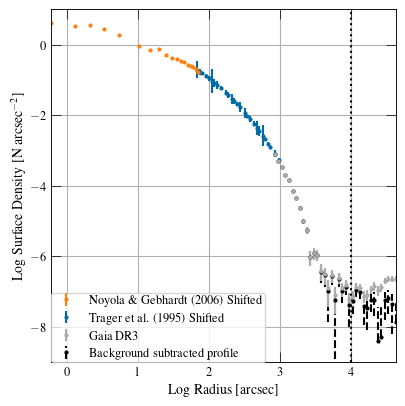

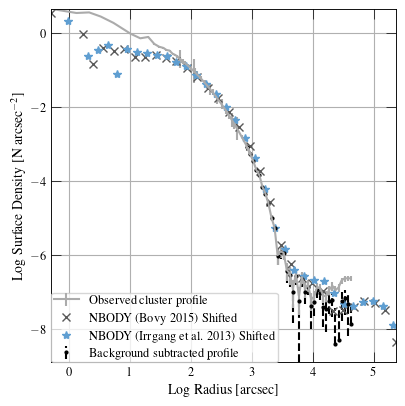

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib_inline
import orbits

mpl.style.use('default')
mpl.style.use('tableau-colorblind10')
mpl.style.use('./MNRAS_Style.mplstyle')
mpl.rcParams['figure.figsize'] = [12/3, 12/3]

SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

nbody = np.loadtxt('2024-04-07/ngc6397.out')
nbody_irr = np.loadtxt('2024-04-28/ngc6397.out')

def get_nbdis(nb):
    m80 = (nb[:,8] < 7) & (nb[:,7] > 0.7) 
    d = 3600.0 * np.sqrt((nb[:,1][m80]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(nb[:,2][m80]-orbits.DEC)**2) 
    return d

nbdis = get_nbdis(nbody)
nbdis_irr = get_nbdis(nbody_irr)

#print("NB Bovy @ M > 0.7", len(nbdis))
#print("NB Irrg @ M > 0.7", len(nbdis_irr))

def nice_error(y, e):
    err = np.ma.abs(y - np.ma.log10(10**y + [e, e] * np.array([[-1], [1]])))
    return err.filled(0)
    
def surface_density(dx, ax, label, fmt, color, ref=None, sbshft=12.9):
    logbins = np.logspace(np.log10(np.amin(dx)), np.log10(np.amax(dx)), 35)
    counts, edges = np.histogram(dx, bins=np.hstack(([0], logbins)))
    mask = counts > 0
    
    area = np.pi * (edges[1:]**2 - edges[:-1]**2)
    
    #print(counts, edges, area)
    n = counts[mask]
    n_area = (n / area[mask])
    nsq_area = np.sqrt(n) / area[mask]

    
    x = np.log10(edges[1:][mask])
    y = np.log10(n_area)
    
    # determine shift
    if ref is not None:
        r = (x>1) & (x<4)
        yi = np.interp(x[r], ref[:,0], ref[:,1])
        dy = yi - y[r]
        sbshft = np.mean(dy)
        print(f'Found shift {sbshft}')
    y += sbshft
        
    error = nsq_area
    #print(error)
    
    errn = np.ma.log10(10**y + error) - y
    errp = y - np.ma.log10(10**y - error)
    #print(errn)
    #print(errp)

    #return ax.errorbar(x, y, yerr=[errp.filled(0), errn.filled(0)], label=label, fmt=fmt, color=color)
    return ax.plot(x, y, fmt, label=label, color=color)

trager = np.loadtxt('./ngc6397_trager.dat')
trager = trager[(np.abs(trager[:,3]) < 1) & (trager[:,0] >= 1.82) & (trager[:,0] < 2.983)]
groups = np.split(trager, np.unique(trager[:,0], return_index=True)[1][1:])
maxerr = [np.abs(a[:,3]).argmax(axis=0) for a in groups]
trager = np.array([g[m] for g,m in zip(groups, maxerr)])

rem = [(trager[1:,0] - trager[:-1,0]) < 0.03]
while np.any(rem):
    i = 1 + np.argmax(rem)
    trager = np.delete(trager, i, axis=0)
    rem = [(trager[1:,0] - trager[:-1,0]) < 0.03]

trager_err = np.abs(trager[:,3])
cut_trager = (trager_err < 1) & (trager[:,0] > 1.82) & (trager[:,0] < 2.983)
trager = trager[cut_trager]

noyola = np.loadtxt('n6397_SB_noyola.txt')
noyola_err = np.abs(noyola[:,2])
cut_noyola = (noyola_err < 1)
noyola = noyola[cut_noyola]

# Plot
fig, ax = plt.subplots(ncols=1)
fig.tight_layout()

ax.set_xlabel(r'Log Radius [arcsec]')
ax.set_ylabel(r'Log Surface Density [N arcsec$^{-2}$]')
ax.grid()
ax.minorticks_off()



sdens = np.loadtxt('./sdens')
sdens = sdens[sdens[:,0] >= 2.925]

serrn = np.log10(10**sdens[:,2] + sdens[:,3]) - sdens[:,2]
serrp = sdens[:,2] - np.ma.log10(10**sdens[:,2] - sdens[:,3])
l1 = ax.errorbar(sdens[:,0], sdens[:,2], yerr=[serrp.filled(0), serrn], ms=2, fmt='o', color='k', label='Background subtracted profile')
l1[-1][0].set_linestyle('--')

ty = -0.4*trager[:,2]+6.78
terrn = 0.4*np.abs(trager[:,3])
l2 = ax.errorbar(trager[:,0], ty, yerr=terrn, ms=2, fmt='o', label='Trager et al. (1995) Shifted')

ny = -0.4*noyola[:,1]+6.78
nerrn = np.log10(10**ny + 0.4*noyola[:,2]) - ny
nerrp = ny - np.log10(10**ny - 0.4*noyola[:,2])
l3 = ax.errorbar(noyola[:,0], ny, yerr=[nerrp, nerrn], ms=2, fmt='o', label='Noyola \\& Gebhardt (2006) Shifted')

gerrn = np.log10(10**sdens[:,1] + sdens[:,3]) - sdens[:,1]
gerrp = sdens[:,1] - np.log10(10**sdens[:,1] - sdens[:,3])
l4 = ax.errorbar(sdens[:,0], sdens[:,1], yerr=[gerrp, gerrn], ms=2, fmt='o', label='Gaia DR3')

ax.vlines(4, -9, 1, colors='k', linestyles='dotted')

ax.legend(loc='lower left', handles=[l3, l2, l4, l1], borderaxespad=0., borderpad=0.2)


fig.savefig('sb-subtracted.pdf')

fig, ax = plt.subplots(ncols=1)
fig.tight_layout()

ax.set_xlabel(r'Log Radius [arcsec]')
ax.set_ylabel(r'Log Surface Density [N arcsec$^{-2}$]')
ax.grid()
ax.minorticks_off()

combined = np.vstack((
    np.column_stack((noyola[:,0], ny, nerrp, nerrn)),
    np.column_stack((trager[:,0], ty, terrn, terrn)),
    np.column_stack((sdens[:,0], sdens[:,1], gerrp, gerrn))
))


l1 = ax.errorbar(sdens[:,0], sdens[:,2], yerr=[serrp.filled(0), serrn], ms=2, fmt='o', color='k', label='Background subtracted profile')
l1[-1][0].set_linestyle('--')
l2 = ax.errorbar(combined[:,0], combined[:,1], yerr=combined[:,2:].T, ms=2, fmt='-', color=colors[2], label='Observed cluster profile')
l3 = surface_density(nbdis, ax, 'NBODY (Bovy 2015) Shifted', fmt='x', color='#595959', ref=combined)
l4 = surface_density(nbdis_irr, ax, 'NBODY (Irrgang et al. 2013) Shifted', fmt='*', color='#5F9ED1', ref=combined)
ax.legend(loc='lower left', handles=[l2] + l3 + l4 + [l1], borderaxespad=0., borderpad=0.2)
fig.savefig('sb-nb-shifted.pdf')




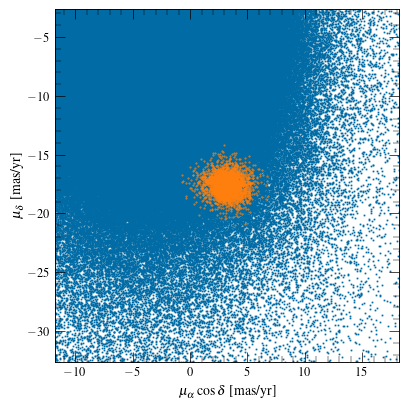

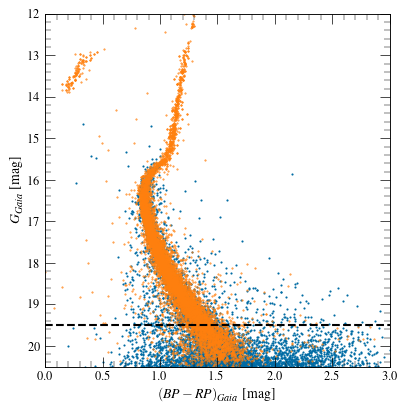

In [2]:
import gaia
from geom import angular_dist, deg2rad


cut = (gaia.data['bp_rp'] != 0)
clean = gaia.data[cut]

distances = angular_dist(clean['ra'], clean['dec'], orbits.RA, orbits.DEC)
gaia_inner = distances < deg2rad(3.0)


# PM & Parallax cut
chi2 = 2
cut = (clean['pmra'] - orbits.PMRA)**2 / (0.2**2 + clean['pmra_error']**2) + \
       (clean['pmdec'] - orbits.PMDEC)**2 / (0.5**2 + clean['pmdec_error']**2) < chi2

chi2 = 3
cut &= (clean['parallax'] - 0.403)**2 / (clean['parallax_error']**2 + 0.05**2) < chi2

# PM
fig, ax = plt.subplots(ncols=1)
fig.tight_layout()
ax.set(
    xlim=[orbits.PMRA-15, orbits.PMRA+15],
    ylim=[orbits.PMDEC-15, orbits.PMDEC+15]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars outside the proper motion space
ax.scatter(clean['pmra'][gaia_inner & ~cut], clean['pmdec'][gaia_inner & ~cut], s=0.2, marker='x', rasterized=True)

# Stars inside the proper motion space
ax.scatter(clean['pmra'][gaia_inner & cut], clean['pmdec'][gaia_inner & cut], s=0.2, marker='o', rasterized=True)
fig.savefig('pm-new.pdf')

# CMD
bg = clean[cut]

pmem = np.loadtxt('ngc6397_pmem')
distances = angular_dist(pmem[:,0], pmem[:,1], orbits.RA, orbits.DEC)
inner = distances < deg2rad(3.0)

fig, ax = plt.subplots(ncols=1)
fig.tight_layout()
ax.invert_yaxis()
ax.set_xlabel('$(BP-RP)_{Gaia}$ [mag]')
ax.set_ylabel('$G_{Gaia}$ [mag]')
ax.set(
    #title=r'Colour-magnitude Diagram',
    xlim=[0.0, 3.0],
    ylim=[20.5, 12]
)

incl=np.full(len(bg), True)
for ra,dec in pmem[:,:2]:
    dr = (bg['ra']- ra)**2 + (bg['dec']-dec)**2
    index = np.argmin(dr)
    incl[index] = False

# Move some from bg to foreground
bg_g = bg['phot_g_mean_mag']
bg_bp_rp = bg['bp_rp']

addit = (bg_g > 12) & (bg_g < 14) & (bg_bp_rp >= 0) & (bg_bp_rp <= 1.5)
addit |= (bg_g < 16) & (bg_g > 12) & (bg_bp_rp >= 1) & (bg_bp_rp <= 1.5)

incl &= ~addit

bp_rp = pmem[:,3] - pmem[:,4]
g = pmem[:,2]
ok = ~((pmem[:,3] == 0) & (pmem[:,4] == 0)) & inner

g = np.append(g, bg_g[addit])
bp_rp = np.append(bp_rp, bg_bp_rp[addit])
ok = np.append(ok, np.full(np.sum(addit), True))

ax.scatter(bg['bp_rp'][incl], bg['phot_g_mean_mag'][incl], s=0.3, marker='x', rasterized=True)
ax.scatter(bp_rp[ok], g[ok], s=0.2, marker='o', rasterized=True)

ax.hlines(19.5, 0, 3, colors='k', linestyles='dashed')

fig.savefig('cm-new.pdf')

total 12821 inner 10480 outlier 2348
total 12821 inner 10357 outlier 2474
total 12821 inner 10480 outlier 2348
total 12821 inner 10357 outlier 2476


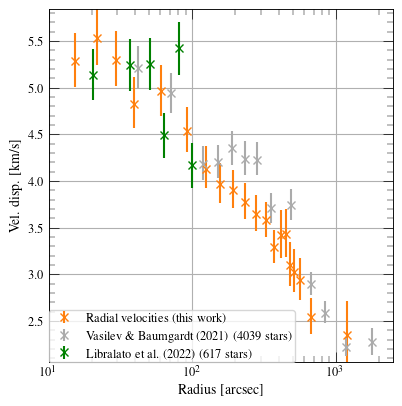

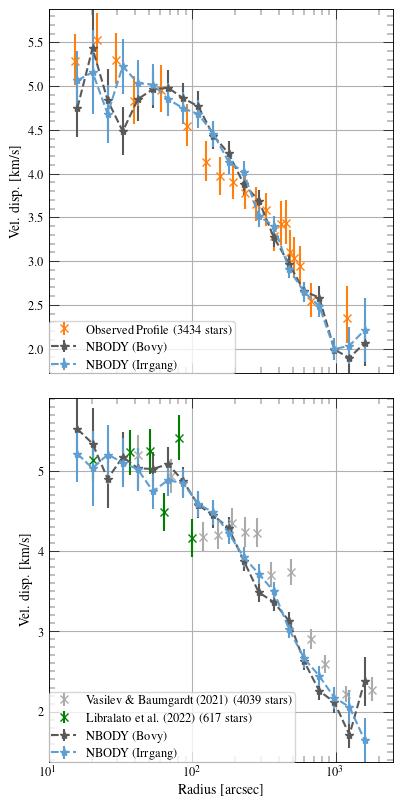

In [7]:
# Vel. disp.
from astropy import units as u
import veldis
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
nb8_cen = [orbits.RA, orbits.DEC]

def plot_velocity_dispersion(save):

    
    def get_veldis(vel, dx, logbins=None):
        if logbins is None:
            logbins = np.logspace(1.2, 3.2, num=20)
            
        #hi = 10**(np.log10(logbins[-1])+0.1)
        hi = 5000
        
        nbinner = (dx < hi)
        nb_v_mean = np.mean(vel[nbinner])
        outlier = ~nbinner | (np.abs(vel - nb_v_mean) > 25)
        print(f"total {len(vel)} inner {np.sum(nbinner)} outlier {np.sum(outlier)}")
        
        hist = []
        bins = []
        errs = []
        ns = 0
        r_0 = 0
        for i,r in enumerate(logbins):
            r_1 = 10**(np.log10(r)+0.1)
            
            bds = ~outlier & (dx > r_0) & (dx < r_1)
            n = np.sum(bds)
            #if n == 0:
            #    continue
            s = np.sqrt(1/n * np.sum((vel[bds] - nb_v_mean)**2.0))
            ns += n
            error = s / np.sqrt(n)
    
            hist.append(s)
            bins.append(r)
            errs.append(error)
            r_0 = r_1
    
        return np.array(hist), np.array(errs), np.array(bins)
    
    
    def tangent_to_velocity(mas):
        return mas.value/3600/180*np.pi * orbits.RSUN * 3.085677E16 / 3.15576e7 / 1000
    
    
    def plot_veldis_nb(ax, label, nb, type, color, fmt='--*'):
        #ax1, ax2 = axes
        if type == 'pm':
            m80 = (nb[:,8] < 10) & (nb[:,7] > 0.7) 
        else:
            m80 = (nb[:,8] < 10) & (nb[:,7] > 0.7) 
        bright = nb[m80]
        
        nbdx = 3600.0 * np.sqrt((bright[:,1]-nb8_cen[0])**2 * np.cos(nb8_cen[1]/180.0*np.pi)**2+(bright[:,2]-nb8_cen[1])**2) 

        if type == 'pm':
            ve = tangent_to_velocity(bright[:,4] * u.mas/u.yr)
            vn = tangent_to_velocity(bright[:,5] * u.mas/u.yr)
            nbpm = np.sqrt(ve**2 + vn**2)
            
            nbvd, nberr, nbvb = get_veldis(nbpm, nbdx)
            ax.errorbar(nbvb, nbvd, nberr, label=f'{label}', color=color, fmt=fmt)
            
        elif type == 'radial':
            nbvr = bright[:,6] # * u.km/u.s
            nbvd, nberr, nbvb = get_veldis(nbvr, nbdx)
            ax.errorbar(nbvb, nbvd, yerr=nberr, label=f'{label}', color=color, fmt=fmt)
        
    
    def plot_veldis_type(ax, t, label, **kwargs):
    
        vcut = (veldis.data_update['type'] == t) & (veldis.data_update['R'] > 10)
        verru = veldis.data_update['esig_u'][vcut]
        verrl = veldis.data_update['e_sigl'][vcut]
        verr = np.vstack((verrl, verru))
        ax.errorbar(veldis.data_update['R'][vcut], veldis.data_update['sig'][vcut], verr, label=label, **kwargs)
        
    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.set(
        ylabel=r'Vel. disp. [km/s]',
        xlim=[10, 2500],
        xlabel=r'Radius [arcsec]'
    )
    ax.set_xscale("log")
    ax.grid()
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    plot_veldis_type(ax, 1, 'Radial velocities (this work)', fmt='C1x')
    plot_veldis_type(ax, 4, 'Vasilev \\& Baumgardt (2021) (4039 stars)', fmt='C2x')
    plot_veldis_type(ax, 2, 'Libralato et al. (2022) (617 stars)', fmt='gx')
    
    ax.legend(loc='lower left', borderaxespad=0., borderpad=0.2)
    fig.savefig('veldisp.pdf')
    
    fig, axes = plt.subplots(nrows=2, figsize=(12/3, 24/3), sharex=True)
    fig.tight_layout()
    
    axes[0].set(
        ylabel=r'Vel. disp. [km/s]',
        xlim=[10, 2500]
    )
    axes[1].set(
        ylabel=r'Vel. disp. [km/s]',
        xlabel=r'Radius [arcsec]',
        xlim=[10, 2500]
    )
    
    for ax in axes:
        ax.set_xscale("log")
        ax.grid()
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    plot_veldis_type(axes[0], 1, 'Observed Profile (3434 stars)', fmt='C1x')
    plot_veldis_type(axes[1], 4, 'Vasilev \\& Baumgardt (2021) (4039 stars)', fmt='C2x')
    plot_veldis_type(axes[1], 2, 'Libralato et al. (2022) (617 stars)', fmt='gx')
    
    plot_veldis_nb(axes[0], 'NBODY (Bovy)', nbody, 'radial', '#595959')
    plot_veldis_nb(axes[0], 'NBODY (Irrgang)', nbody_irr, 'radial', '#5F9ED1')
    plot_veldis_nb(axes[1], 'NBODY (Bovy)', nbody, 'pm', '#595959')
    plot_veldis_nb(axes[1], 'NBODY (Irrgang)', nbody_irr, 'pm', '#5F9ED1')
        
    for ax in axes:
        ax.legend(loc='lower left', borderaxespad=0., borderpad=0.2)
    fig.savefig(save)

plot_velocity_dispersion('veldisp-nb.pdf')

0.018124568960391857 12913.183838041072
14.07708
Inner 0.05pc mass = 7.318450000000001 | n = 7
Inner 0.26pc mass = 777.94218 | n = 886
7.786128984635174
941.8559609920285


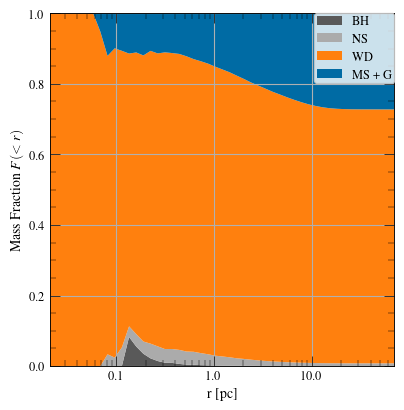

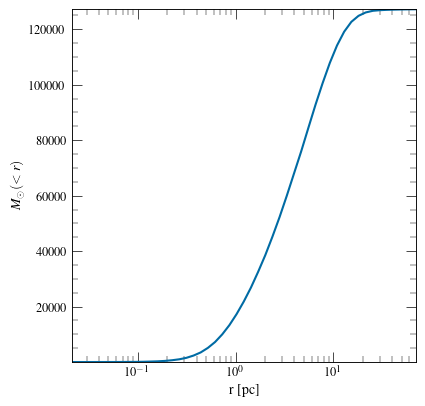

In [4]:
nbform = np.loadtxt('2024-04-07/ngc6397.nbform')
#out = np.loadtxt('2024-04-07/ngc6397.out')
nborb = np.loadtxt('2024-04-07/orbit')

#d = 3600.0 * np.sqrt((nbody[:,1]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(nbody[:,2]-orbits.DEC)**2) 
#d = np.sqrt(
#    (nbform[:,1]-nborb[-1,1])**2 +
#    (nbform[:,2]-nborb[-1,2])**2 +
#    (nbform[:,3]-nborb[-1,3])**2
#)

d = np.sqrt(np.sum(nbform[:,7:10]**2, axis=1))

print(np.amin(d), np.amax(d))

wd = (nbform[:,-1]) >= 10 & (nbform[:,-1] < 13)
ns = nbform[:,-1] == 13
bh = nbform[:,-1] == 14
ms = nbform[:,-1] < 10
mass = nbform[:,0]

close = d < 70

print (mass.max())
print (f"Inner 0.05pc mass = {np.sum(mass[d < 0.05])} | n = {np.sum(d < 0.05)}")
print (f"Inner 0.26pc mass = {np.sum(mass[d < 0.26])} | n = {np.sum(d < 0.26)}")

bins = np.logspace(-1.75, 1.845, num=50)
m = []
w = []
b = []
n = []
for bin in bins:
    inside = d < bin
    #print(b, np.sum(inside&wd), np.sum(inside&ms))
    m.append(np.sum(mass[inside & ms]))
    w.append(np.sum(mass[inside & wd]))
    b.append(np.sum(mass[inside & bh]))
    n.append(np.sum(mass[inside & ns]))

m = np.array(m)
w = np.array(w)
b = np.array(b)
n = np.array(n)
bins = np.array(bins)
c = m + w + b + n
z = c == 0

c = c[~z]
m = m[~z] / c 
w = w[~z] / c
b = b[~z] / c
n = n[~z] / c
bins = bins[~z]

fig, ax = plt.subplots()
fig.tight_layout()
ax.set_ylabel('Mass Fraction $F(<r)$')
ax.set_xlabel('r [pc]')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid()
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='x', which='minor')

formatter = mpl.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
ax.stackplot(bins, [b,n,w,m], labels=['BH', 'NS', 'WD', 'MS + G'], colors=[colors[3], colors[2], colors[1], colors[0]])
#ax.plot(bins, m, label='MS + G')
#ax.plot(bins, w, label='WD')
#ax.plot(bins, n, label='NS')
#ax.plot(bins, b, label='BH')
ax.legend(loc='upper right', borderaxespad=0., borderpad=0.2)

fig.savefig('compact_mass.pdf')


fig, ax = plt.subplots()
fig.tight_layout()
ax.set_ylabel(r'$M_{\odot}(<r)$')

ax.plot(bins, c)

ax.set_xlabel('r [pc]')
ax.set_xscale("log")
#ax.set_yscale("log")
#print(c)
#print(bins)

fig.savefig('mass_radius.pdf')

print(np.interp(0.05, bins, c))
print(np.interp(0.26, bins, c))


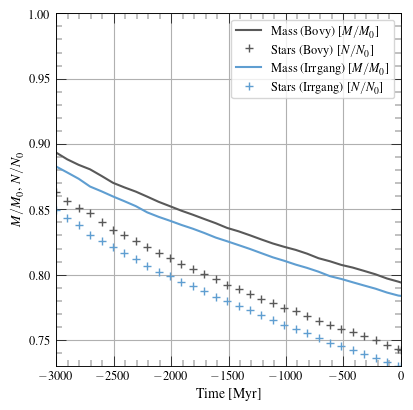

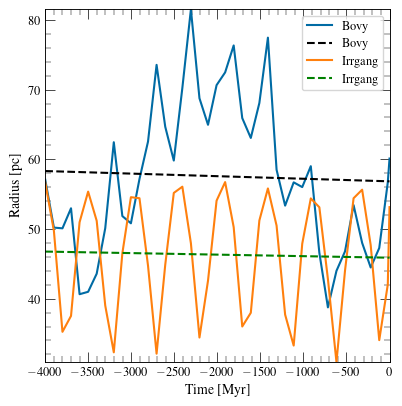

In [5]:

boundm_bovy = np.loadtxt('2024-04-07/boundm')
boundm_irr = np.loadtxt('2024-04-28/boundm')
boundm_bovy[0,0] = 9500
boundm_irr[0,0] = 9500
    
fig, ax = plt.subplots()
fig.tight_layout()

ax.set_xlim(-3000, 0)
ax.set_ylabel('$M/M_0$, $N/N_0$')
ax.set_xlabel('Time [Myr]')
ax.grid()
ax.plot(boundm_bovy[:,0] - 13500, boundm_bovy[:,2], color='#595959', label='Mass (Bovy) [$M/M_0$]')
ax.plot(boundm_bovy[:,0] - 13500, boundm_bovy[:,3], '+', color='#595959', label='Stars (Bovy) [$N/N_0$]')

ax.plot(boundm_irr[:,0] - 13500, boundm_irr[:,2], color='#5F9ED1', label='Mass (Irrgang) [$M/M_0$]')
ax.plot(boundm_irr[:,0] - 13500, boundm_irr[:,3], '+', color='#5F9ED1', label='Stars (Irrgang) [$N/N_0$]')
ax.legend()
fig.savefig('boundm.pdf')


fig, ax = plt.subplots()
fig.tight_layout()
ax.set_ylabel('Radius [pc]')
ax.set_xlabel('Time [Myr]')

def plot_r(boundm, ax, fmt, label):
    x = boundm[:,0] - 13500
    y = boundm[:,1]
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 

    ax.plot(x, y, '-', x, poly1d_fn(x), fmt, label=label)

plot_r(boundm_bovy, ax, '--k', 'Bovy')
plot_r(boundm_irr, ax, '--g', 'Irrgang')
ax.legend()

fig.savefig('r.pdf')
